In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import sys
import tensorflow as tf

proj_home_path="C:/vrsk.psk.family/Selva/BitsPilani/azure/semester4/semester4/SuperPoint"
sys.path.append(proj_home_path)

from superpoint.settings import EXPER_PATH
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
def _read_image_retail(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_png(image,channels=3)
    return tf.cast(image, tf.float32)

def _read_image(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_png(image, channels=1)
    return tf.cast(image, tf.float32)

# Python function
def _read_points(filename):
    return np.load(filename.decode('utf-8')).astype(np.float32)

def draw_keypoints(img, corners, color):
    keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in corners]
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

def display(d):
    return draw_keypoints(d['image'], d['keypoints'], (0, 255, 0))

def getRetailDataIter(image_location_dir, images):
    
    data = tf.data.Dataset.from_tensor_slices(images)
#     data = data.map(lambda image: (_read_image_retail(image_location_dir+image)))
#     data = data.map(lambda image: {'image': image})
    data = data.map(lambda image: image_location_dir+image)
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)
    
def getDataIter(shape_dir_list,num_images_per_shape,data_dir, img_dir,p_dir):
    '''
        shape_dir_list : directory name that holds specific type of shapes
        num_images_per_shape: number of images randomly picked from the shapes directory
        data_dir: base directory for both images and corner points
        idir: full directory path for specifc shape generation
        pdir: full directory path for specifc corner points generation
    '''
    #================= LIST RANDOM FILES =============================
    ifiles =  []
    pfiles = []
 
    # Randomly pick num_images_per_shape count of images
    for sdir in shape_dir_list:
        idir = data_dir+sdir+img_dir
        pdir = data_dir+sdir+p_dir
        ifiles_list = [f for f in os.listdir(idir)]
        random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
        random_pfiles = [ f.replace(".png",".npy") for f in random_ifiles]
        random_ifiles = [os.path.join(idir, f) for f in random_ifiles]
        random_pfiles = [os.path.join(pdir, f) for f in random_pfiles]
            
        # Accumulate images in list for later operations.
        if ifiles == None:
            ifiles = random_ifiles
            pfiles = random_pfiles
        else:    
            ifiles = ifiles + random_ifiles
            pfiles = pfiles + random_pfiles

    #================ READ LISTED FILES ===========================
    data = tf.data.Dataset.from_tensor_slices(
            (ifiles, pfiles))
    data = data.map(
            lambda image, points:
            (_read_image(image), tf.py_func(_read_points, [points], tf.float32)))
    data = data.map(lambda image, points: (image, tf.reshape(points, [-1, 2])))
    data = data.map(lambda image, kp: {'image': image, 'keypoints': kp})
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

In [91]:
# Variable declaration.
img_register_path = 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\shopee-product-matching\\'
img_register_file = 'train.csv'
img_location = img_register_path + "train_images\\"
df = pd.read_csv(img_register_path+img_register_file) #, sheetname='train')
df = df.sort_values(by='label_group')
gb = df.groupby(['label_group'])

blocks = [data.sample(n=2) for _,data in gb]
df_sampled = pd.concat(blocks)
images = df_sampled['image'].values
print(df_sampled)

data = getRetailDataIter(img_location,images)

             posting_id                                 image  \
3874   train_1646767365  1d7aadc7503b2b4539cc9a5fe41979dd.jpg   
6738    train_398181303  3301b8aaccea93d1098995ffbc537335.jpg   
12367  train_1382500866  5d075d7eaa258052ab125c75c06293d6.jpg   
7613   train_2865605743  3977f4e7a47c73568c5e9fcb61723b4b.jpg   
14995  train_3645016213  70fe1461e4115c3ba79bbc176ae7a118.jpg   
...                 ...                                   ...   
2598   train_1168451063  13dc07354ad8b7c5dde440d652edfd62.jpg   
19942  train_3902879615  95eb770da42f2d9d89c374093a5b49ef.jpg   
5738   train_3671173710  2b2680539685bd6adada6940e443a1d5.jpg   
5068   train_2305448044  2620f9c53dfb96b578207b15bc740944.jpg   
4554    train_264319412  2254f0b3b2c80b678b41dcd588d77320.jpg   

            image_phash                                              title  \
3874   e925873ed09cd08f  Sarung celana wadimor original 100% dewasa dan...   
6738   e9b5833e929e909c    SARUNG CELANA WADIMOR DEWASA HITAM P

# Display Retail Images

range(0, 24, 2) 12


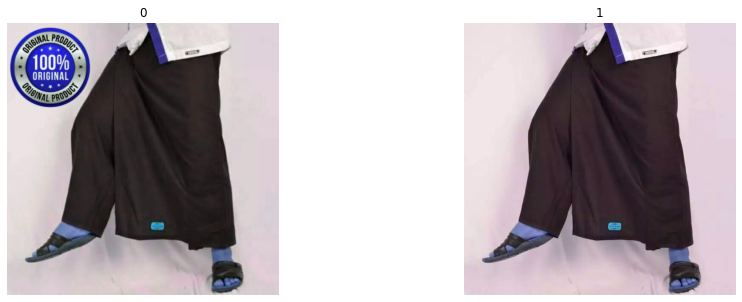

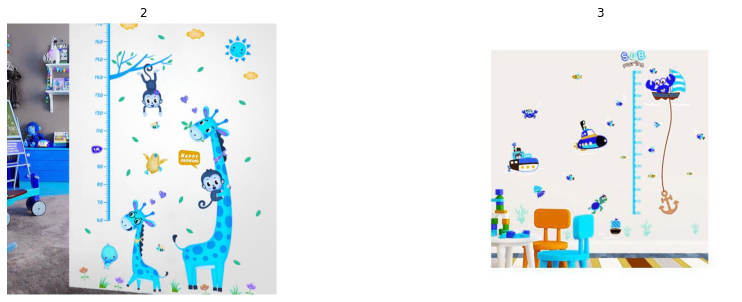

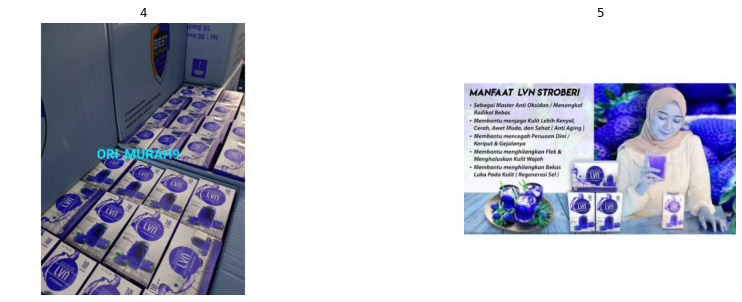

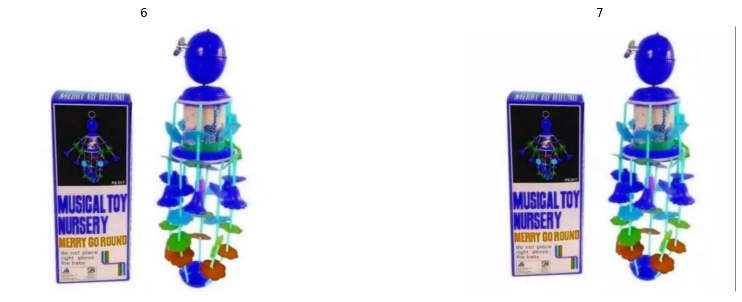

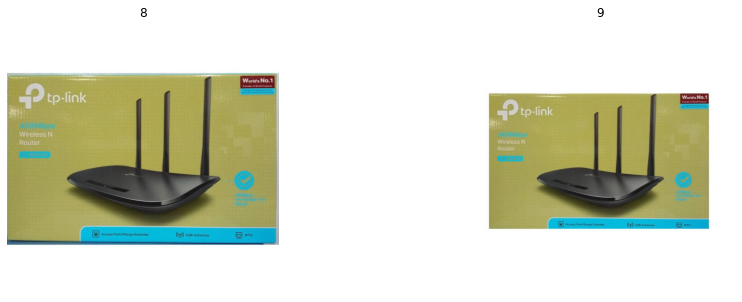

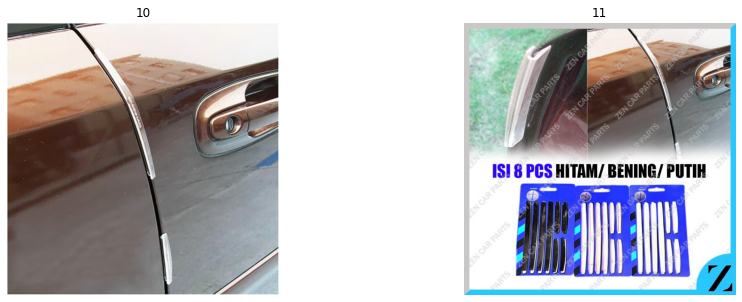

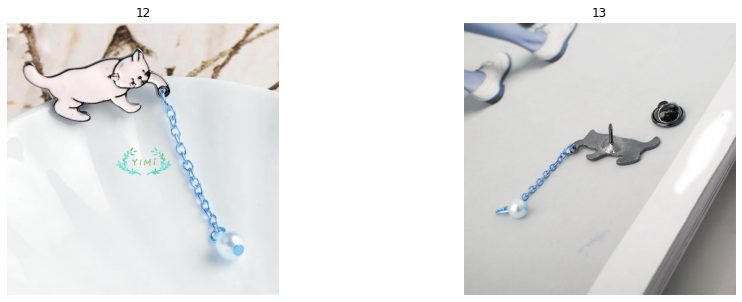

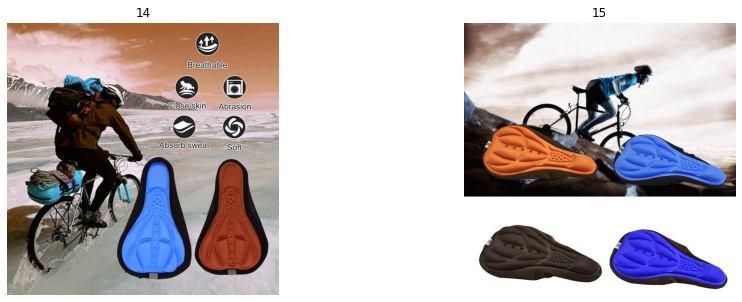

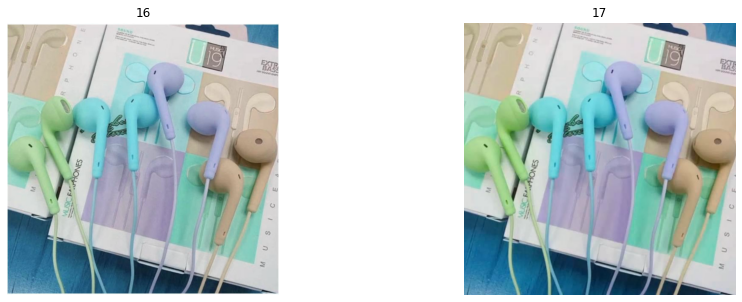

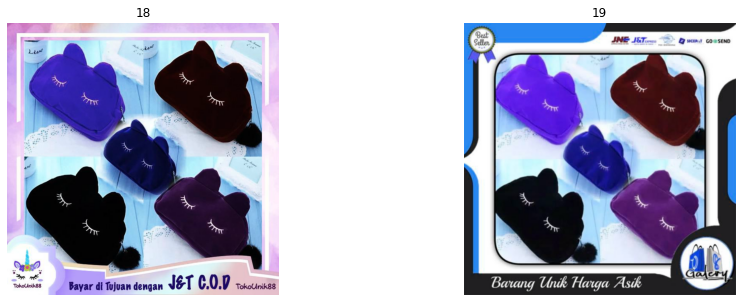

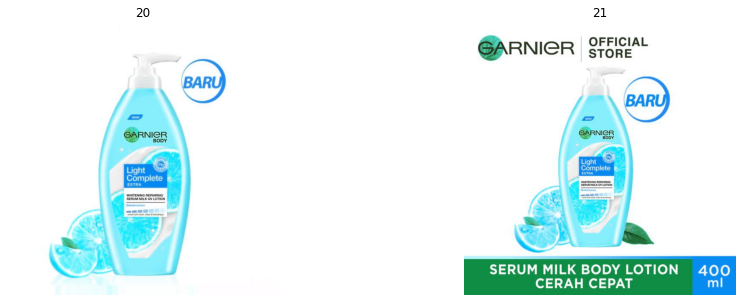

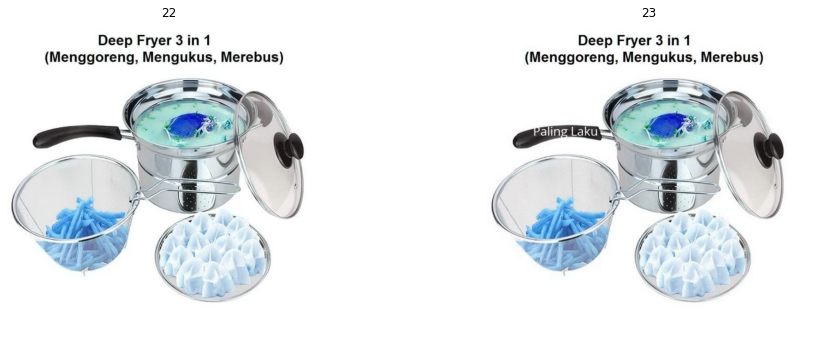

In [92]:
## Plot synthetic images generated.

Tot = 24
Cols = 2

# Compute Rows required
Rows = Tot // Cols  # it should be 14
Rows += Tot % Cols # ZERO added

# Create a Position index
Position = range(0,Tot,Cols)
print(Position, Rows)

for k in Position:
    try:
        fig , a =  plt.subplots(1,Cols, figsize = (15,5))
        for ax, incr in zip(a,range(0,Cols)):
            img_loc = next(data).decode("utf-8") 
#             print(img_loc)
            Image1 = cv2.imread(img_loc)
            ax.imshow(Image1)
            ax.get_yaxis().set_ticks([])
            ax.get_xaxis().set_ticks([])
            ax.set_title(str(k+incr))
            for spine in ax.spines.values():  # remove frame
                spine.set_visible(False)

    except tf.errors.OutOfRangeError:
        break

plt.tight_layout()

# DISPLAY SYNTHETIC DATA

In [10]:
## Utilize above functions to generate image iterator in tensorflow.
# from Pm_Util import getDataIter
import tensorflow as tf

##Shapes generated by synthetic_shapes_generator
shape_dir_list = ['draw_checkerboard','draw_cube','draw_ellipses',
                  'draw_lines','draw_multiple_polygons','draw_star',
                  'draw_stripes','gaussian_noise']
num_images_per_shape = 6
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\tmp\\"
##Generator generates data for train, test and validation. Here picking data from test to view
img_dir = '\\images\\test\\'
p_dir = '\\points\\test\\'


#================ PLOT FILES ==================================
data = getDataIter(shape_dir_list, num_images_per_shape, data_dir, img_dir, p_dir)

range(1, 48, 3) 16
            lambda image, points:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda image, points:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.


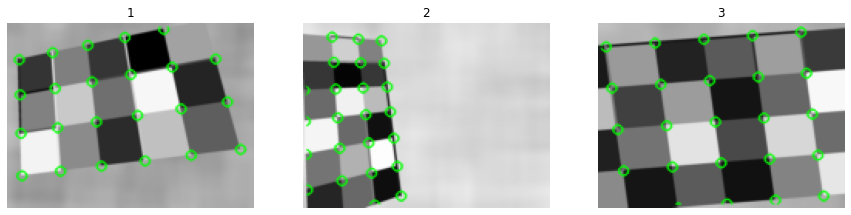

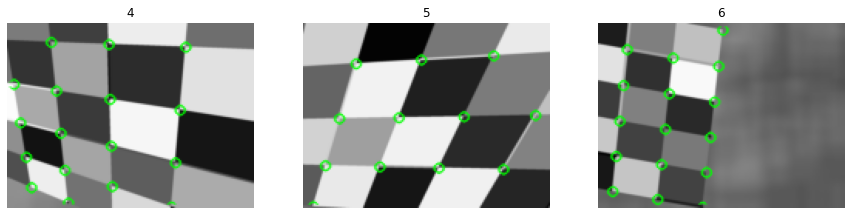

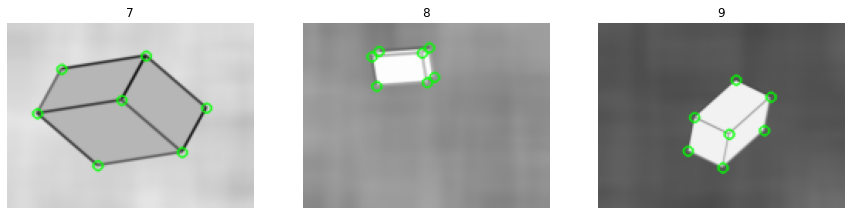

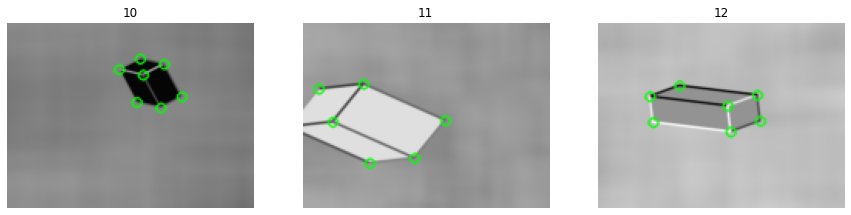

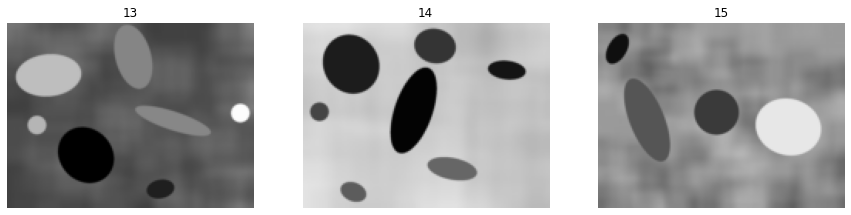

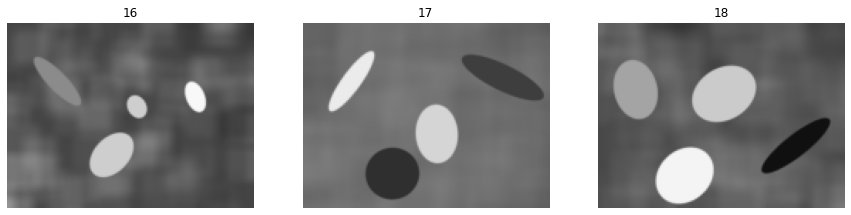

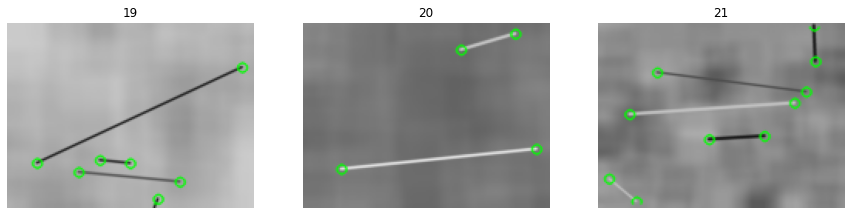

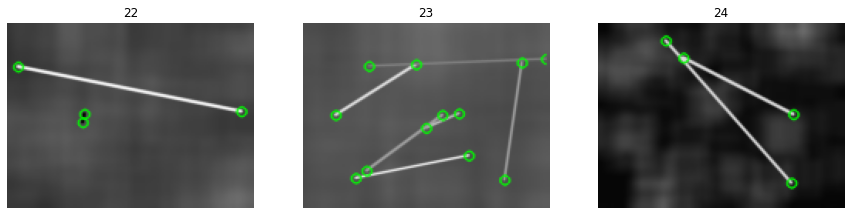

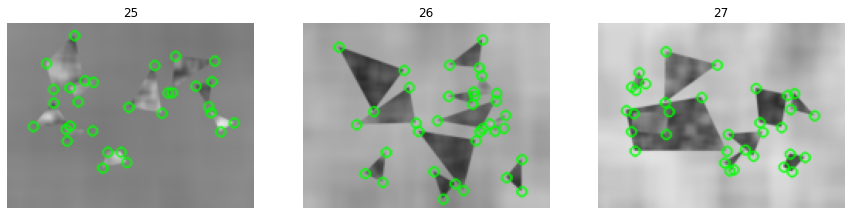

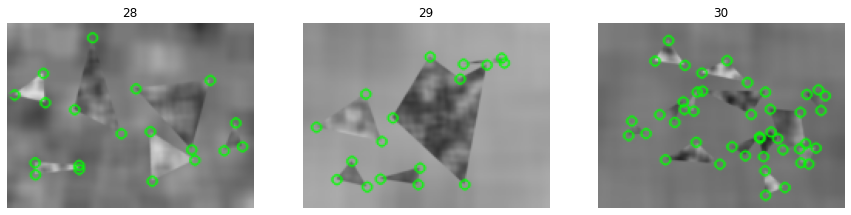

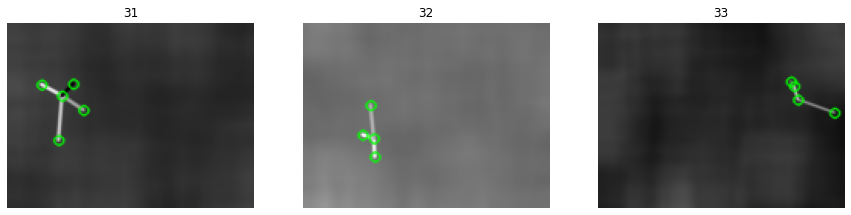

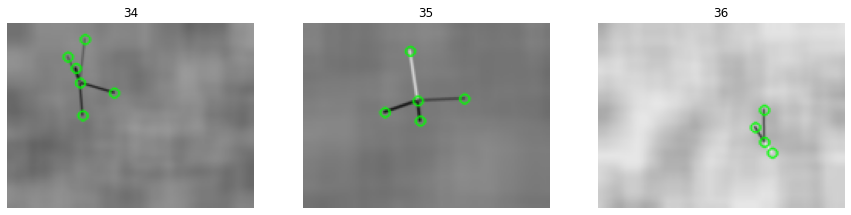

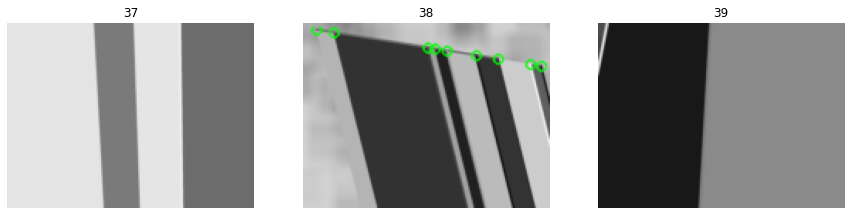

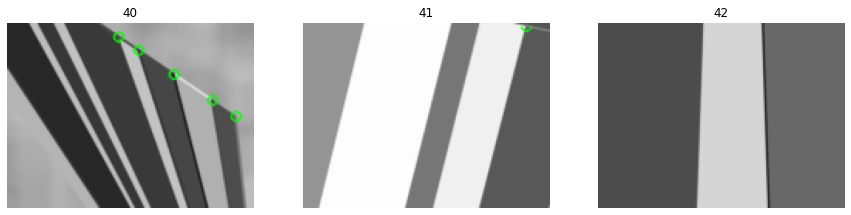

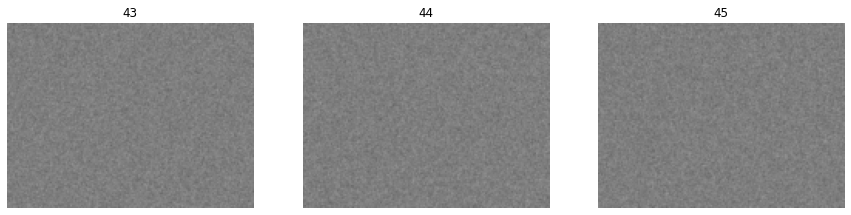

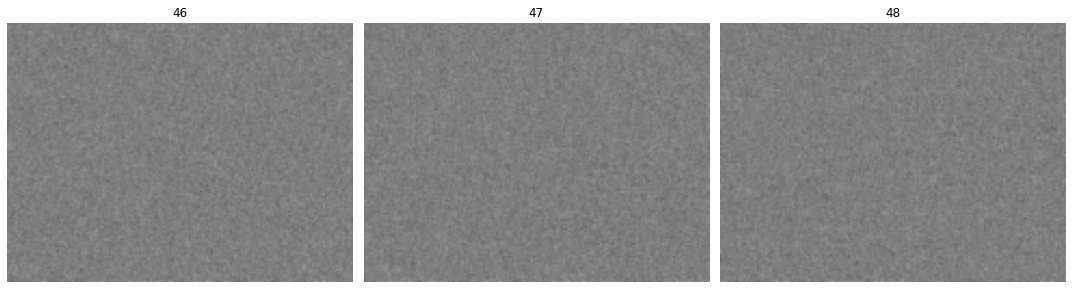

In [11]:
## Plot synthetic images generated.
Tot = len(shape_dir_list) * num_images_per_shape
Cols = 3

# Compute Rows required
Rows = Tot // Cols  # it should be 14
Rows += Tot % Cols # ZERO added

# Create a Position index
Position = range(1,Tot,Cols)
print(Position, Rows)

# _, axs = plt.subplots(1, Tot, figsize=(Cols*Tot, Cols), dpi=100)
# fig, axs = plt.subplots(Rows, Cols, figsize=(10, 3))
for k in Position:
    try:
        fig , a =  plt.subplots(1,Cols, figsize = (15,5))
        for ax, incr in zip(a,range(0,Cols)):
            img = display(next(data))
            ax.imshow(img)
            ax.get_yaxis().set_ticks([])
            ax.get_xaxis().set_ticks([])
            ax.set_title(str(k+incr))
            for spine in ax.spines.values():  # remove frame
                spine.set_visible(False)

    except tf.errors.OutOfRangeError:
        break

plt.tight_layout()
# plt.imgshow()

# End of Visualization of Dataset (Retail dataset + Synthetic Generated dataset)